In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt

**Create Spark Session**

In [2]:
spark = SparkSession.\
        builder.\
        appName('sparkSQL').\
        getOrCreate()

**Create DataFrame**

In [3]:
path = "baskets.csv"

In [4]:
data = spark.read.format('csv').\
        option('inferSchema','true').\
        option('header','true').\
        option('path', path).\
        load()

In [5]:
data.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)



**First 10 items**

In [6]:
unique_sorted_items = data.select('itemDescription').\
                            distinct().\
                            withColumn("itemDescription", lower(data["itemDescription"])).\
                            orderBy('itemDescription', ascending=True)

top_10_items = unique_sorted_items.head(10)

for item in top_10_items:
    print(item['itemDescription'])

abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries
beverages
bottled beer


**Last 10 Items**

In [7]:
last_10_items = unique_sorted_items.tail(10)

for item in last_10_items:
    print(item['itemDescription'])

uht-milk
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


**Top 10 Best-Selling Items**

In [8]:
best_selling = data.groupBy("itemDescription").\
                agg(count("itemDescription").alias("itemCount")).\
                orderBy(col("itemCount").desc())

best_selling.show(10, truncate=False)

+----------------+---------+
|itemDescription |itemCount|
+----------------+---------+
|whole milk      |2502     |
|other vegetables|1898     |
|rolls/buns      |1716     |
|soda            |1514     |
|yogurt          |1334     |
|root vegetables |1071     |
|tropical fruit  |1032     |
|bottled water   |933      |
|sausage         |924      |
|citrus fruit    |812      |
+----------------+---------+
only showing top 10 rows



**Visualize The 20 Best-Selling Items**

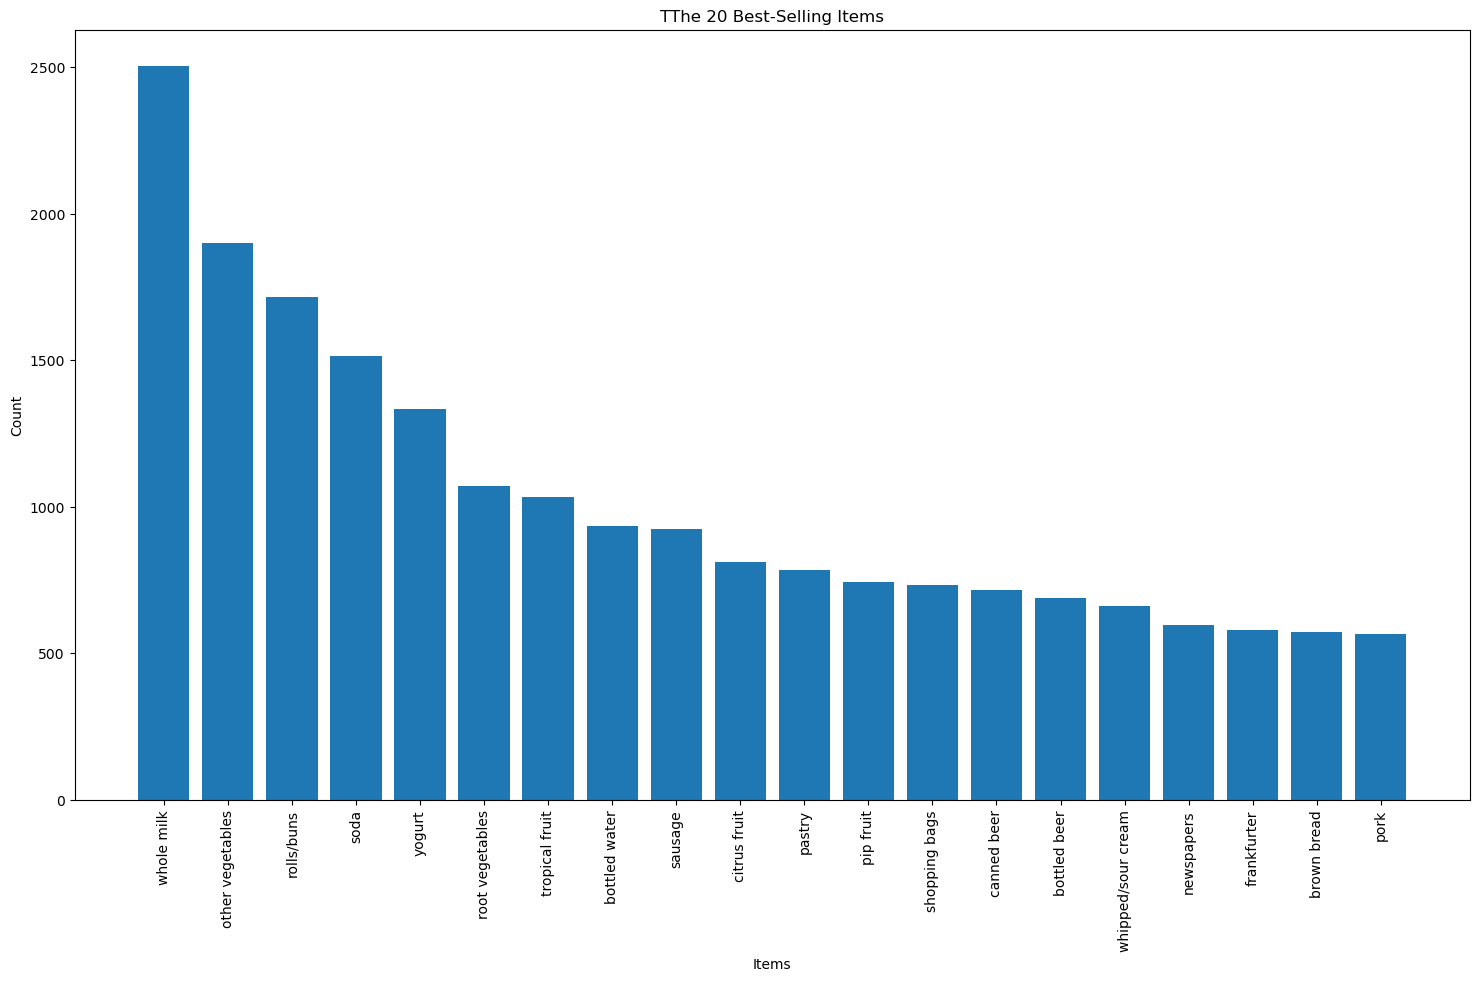

In [9]:
top_20_items = best_selling.take(20)
item_names = [item[0] for item in top_20_items]
item_counts = [item[1] for item in top_20_items]

plt.figure(figsize=(18, 10))
plt.bar(item_names, item_counts)
plt.xlabel('Items')
plt.ylabel('Count')
plt.title('TThe 20 Best-Selling Items')
plt.xticks(rotation=90)
plt.show()

**Top 10 Clients**

In [10]:
cart_count = data.groupBy("Member_number", "Date").\
                agg(countDistinct("itemDescription").alias("unique_items_in_cart"))

cart = cart_count.groupBy("Member_number").\
                agg(count("Date").alias("cart_count")).\
                orderBy(col("cart_count").desc()) 

cart.show(10,truncate=False)

+-------------+----------+
|Member_number|cart_count|
+-------------+----------+
|4338         |11        |
|2193         |11        |
|2271         |11        |
|1379         |11        |
|3737         |11        |
|3180         |10        |
|3593         |10        |
|3120         |10        |
|3484         |10        |
|1574         |10        |
+-------------+----------+
only showing top 10 rows



**Visualize The 20 Clients**

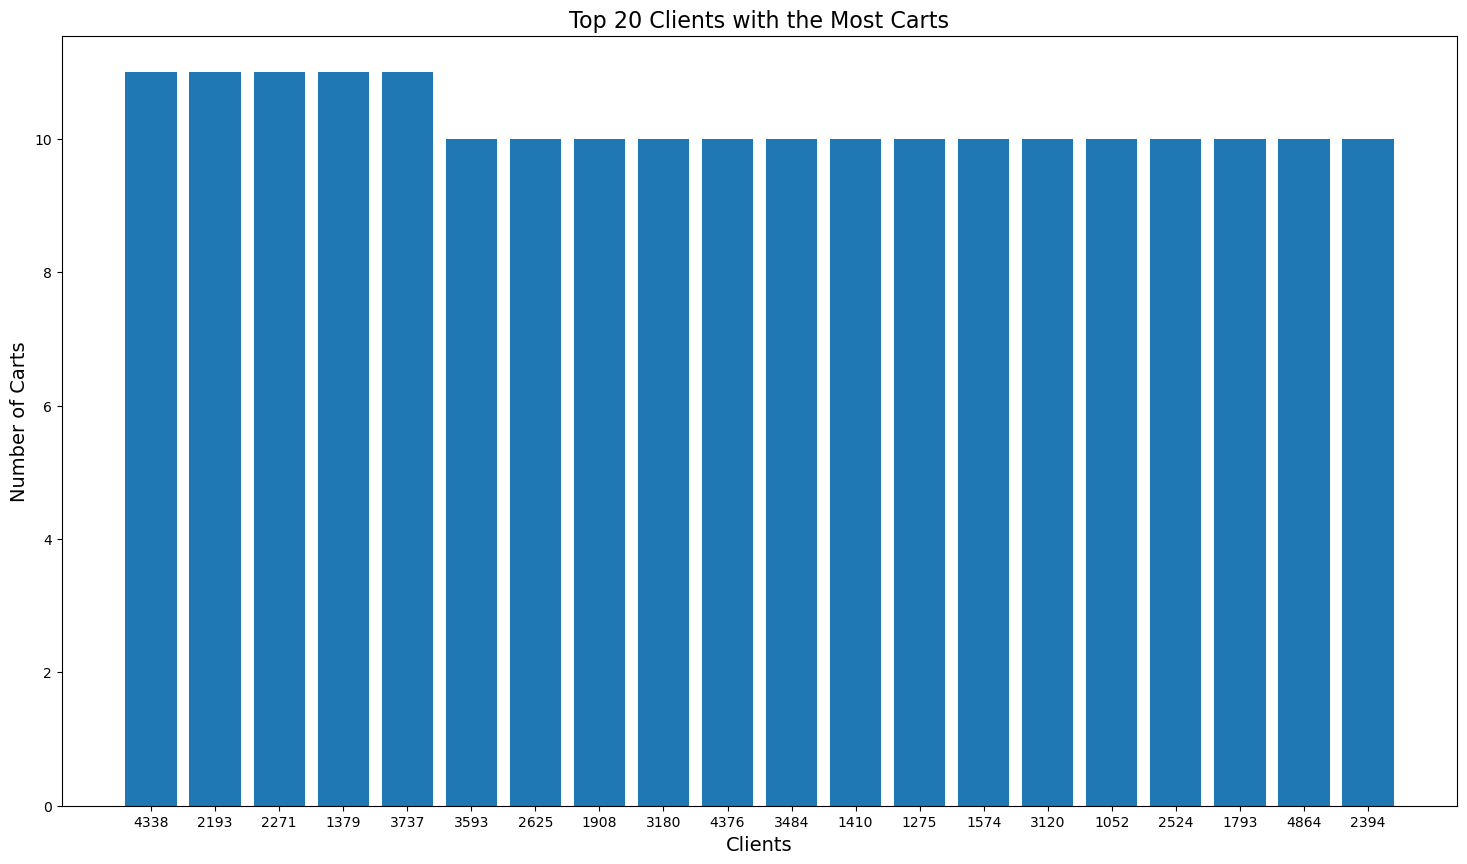

In [11]:
top_20_clients = cart.limit(20).toPandas()

client_names = top_20_clients['Member_number'].astype(str)
cart_counts = top_20_clients['cart_count']

plt.figure(figsize=(18, 10))
plt.bar(client_names, cart_counts)
plt.xlabel('Clients', fontsize=14)
plt.ylabel('Number of Carts', fontsize=14)
plt.title('Top 20 Clients with the Most Carts', fontsize=16)
plt.xticks(rotation=0)
plt.show()

**Top 1 Users**

In [12]:
best_user = data.groupBy("Member_number").\
                agg(countDistinct("itemDescription").alias("item_count")).\
                orderBy(col("item_count").desc()) 

best_user.show(1,truncate=False)

+-------------+----------+
|Member_number|item_count|
+-------------+----------+
|2051         |26        |
+-------------+----------+
only showing top 1 row



**Top 1 Item**

In [13]:
best_item = data.groupBy("itemDescription").\
                agg(countDistinct("Member_number").alias("member_count")).\
                orderBy(col("member_count").desc()) 

best_item.show(1,truncate=False)

+---------------+------------+
|itemDescription|member_count|
+---------------+------------+
|whole milk     |1786        |
+---------------+------------+
only showing top 1 row



**A customer's cart in a day**

In [14]:
df_basket = data.groupBy("Member_number","Date","year","month","day").agg(collect_set("itemDescription").alias("Basket"))

df_basket = df_basket.withColumn("year", col("year").cast("integer"))
df_basket = df_basket.withColumn("month", col("month").cast("integer"))
df_basket = df_basket.withColumn("day", col("day").cast("integer"))

df_basket = df_basket.orderBy(["year", "month", "day"], ascending=True)
df_basket.show(25,truncate=False)

+-------------+----------+----+-----+---+-------------------------------------------------+
|Member_number|Date      |year|month|day|Basket                                           |
+-------------+----------+----+-----+---+-------------------------------------------------+
|1922         |01/01/2014|2014|1    |1  |[tropical fruit, other vegetables]               |
|1381         |01/01/2014|2014|1    |1  |[curd, soda]                                     |
|1440         |01/01/2014|2014|1    |1  |[yogurt, other vegetables]                       |
|1659         |01/01/2014|2014|1    |1  |[specialty chocolate, frozen vegetables]         |
|1789         |01/01/2014|2014|1    |1  |[candles, hamburger meat]                        |
|1249         |01/01/2014|2014|1    |1  |[citrus fruit, coffee]                           |
|2727         |01/01/2014|2014|1    |1  |[hamburger meat, frozen potato products]         |
|2226         |01/01/2014|2014|1    |1  |[sausage, bottled water]               

**Cart in day**

In [15]:
count_basket = df_basket.groupBy("Date","year","month","day").\
                    agg(count("Member_number").alias("member_count")).\
                    orderBy(["year", "month", "day"], ascending=True) 

count_basket.show(10,truncate=False)

+----------+----+-----+---+------------+
|Date      |year|month|day|member_count|
+----------+----+-----+---+------------+
|01/01/2014|2014|1    |1  |21          |
|02/01/2014|2014|1    |2  |29          |
|03/01/2014|2014|1    |3  |24          |
|04/01/2014|2014|1    |4  |28          |
|05/01/2014|2014|1    |5  |20          |
|06/01/2014|2014|1    |6  |13          |
|07/01/2014|2014|1    |7  |16          |
|08/01/2014|2014|1    |8  |19          |
|09/01/2014|2014|1    |9  |28          |
|10/01/2014|2014|1    |10 |23          |
+----------+----+-----+---+------------+
only showing top 10 rows



**Visualize Cart in day**

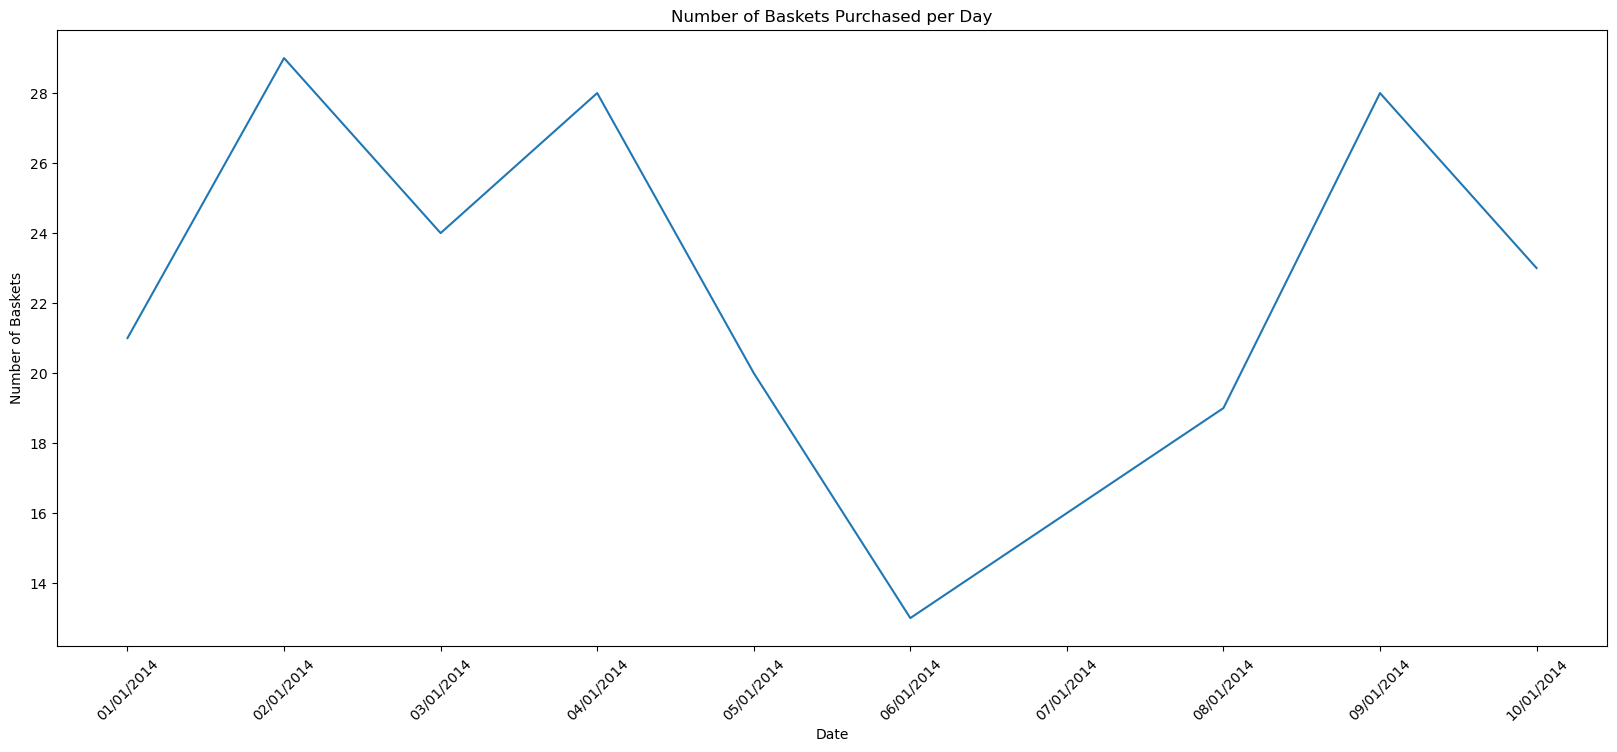

In [16]:
pandas_df = count_basket.limit(10).toPandas()
plt.figure(figsize=(20, 8))
plt.plot(pandas_df["Date"], pandas_df["member_count"])
plt.xlabel("Date")
plt.ylabel("Number of Baskets")
plt.title("Number of Baskets Purchased per Day")
plt.xticks(rotation=45)
plt.show()

In [17]:
spark.stop()